# Comparing permuted versus unpermuted DWPCs

In [1]:
library(magrittr)

In [2]:
dwpc_df = readr::read_tsv('data/matrix/dwpc.tsv.bz2') %>%
  tidyr::gather(metapath, dwpc, -(hetnet:disease_id)) %>%
  dplyr::mutate(permuted = as.integer(grepl('perm', hetnet)))

dwpc_df %>% head(3)

,hetnet,compound_id,disease_id,metapath,dwpc,permuted
1,rephetio-v2.0,DB00014,DOID:0050741,CbG<rG<rGaD,0,0
2,rephetio-v2.0,DB00014,DOID:10283,CbG<rG<rGaD,0,0
3,rephetio-v2.0,DB00014,DOID:10763,CbG<rG<rGaD,0,0


In [3]:
scale_df = dwpc_df %>%
  dplyr::filter(hetnet == 'rephetio-v2.0') %>%
  dplyr::group_by(metapath) %>%
  dplyr::summarize(
    scalar_mean = mean(dwpc),
    scalar_sd = sd(dwpc)
  )

scale_df %>% head(2)

,metapath,scalar_mean,scalar_sd
1,CbGaD,0.004460421,0.01191669
2,CbGaDaGaD,0.007504682,0.008246537


In [4]:
dwpc_df %<>%
  dplyr::inner_join(scale_df) %>%
  dplyr::mutate(tdwpc = asinh(dwpc / scalar_mean))

Joining by: "metapath"


In [5]:
dwpc_df %>% head(2)

,hetnet,compound_id,disease_id,metapath,dwpc,permuted,scalar_mean,scalar_sd,tdwpc
1,rephetio-v2.0,DB00014,DOID:0050741,CbG<rG<rGaD,0,0,0.001484458,0.003023556,0
2,rephetio-v2.0,DB00014,DOID:10283,CbG<rG<rGaD,0,0,0.001484458,0.003023556,0


# metapath-specific z-scores for the effect of permutation on DWPCs

In [6]:
get_z_score <- function(df) {
  mean_df = df %>%
    dplyr::group_by(hetnet, permuted) %>%
    dplyr::summarize(
      mean_tdwpc = mean(tdwpc)
    ) %>%
    dplyr::ungroup()

  perm_x = dplyr::filter(mean_df, permuted == 1)$mean_tdwpc
  x = dplyr::filter(mean_df, permuted == 0)$mean_tdwpc
  z_score = (x - mean(perm_x)) / sd(perm_x)
  return(dplyr::data_frame(z_score = z_score))
}

metapath_df = dwpc_df %>%
  dplyr::group_by(metapath) %>%
  dplyr::do(get_z_score(.)) %>%
  dplyr::ungroup()

In [7]:
zscore_df = metapath_df %>%
  dplyr::arrange(z_score) %>%
  dplyr::mutate(metapath = htmltools::htmlEscape(metapath))

zscore_df %>% head
zscore_df %>% tail

,metapath,z_score
1,CpDrDrDrD,-20.50756
2,CrCrCbGuD,-19.42794
3,CrCrCuGdD,-15.86796
4,CrCrCbGdD,-15.27464
5,CrCrCpD,-14.61597
6,CbGeAuGaD,-13.91783


,metapath,z_score
1,CrCiPCiCtD,31.20396
2,CiPCiCrCtD,35.21899
3,CtDaGiGaD,36.24472
4,CrCrCtD,43.87422
5,CiPCiCtD,46.7302
6,CrCtD,67.60111


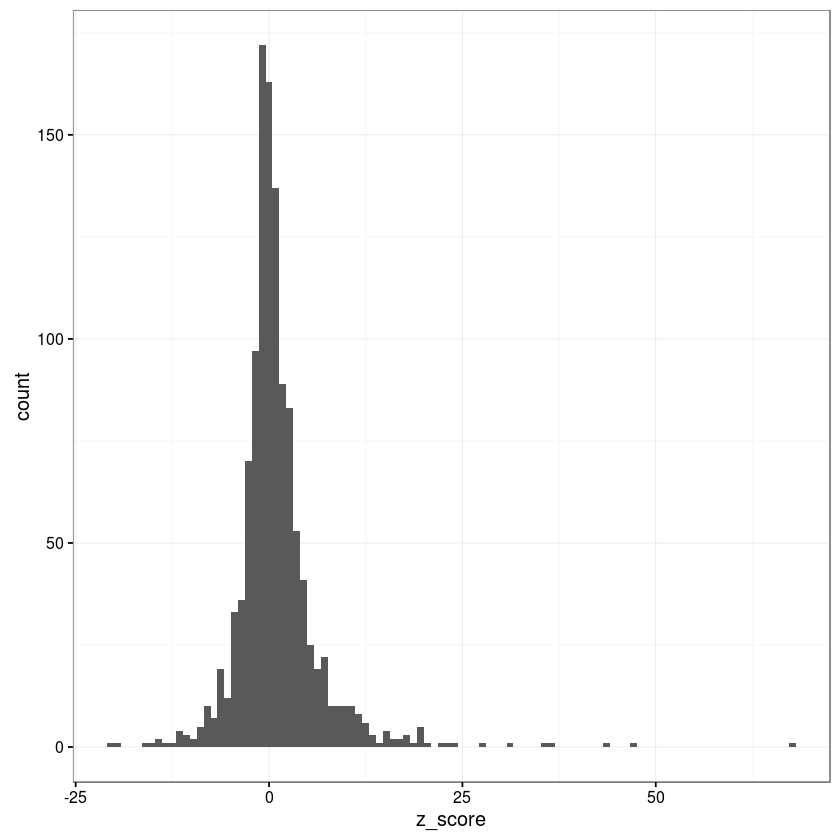

In [8]:
metapath_df %>%
  ggplot2::ggplot(ggplot2::aes(z_score)) +
  ggplot2::geom_histogram(bins=100) +
  ggplot2::theme_bw()

## Randomly selected metapaths

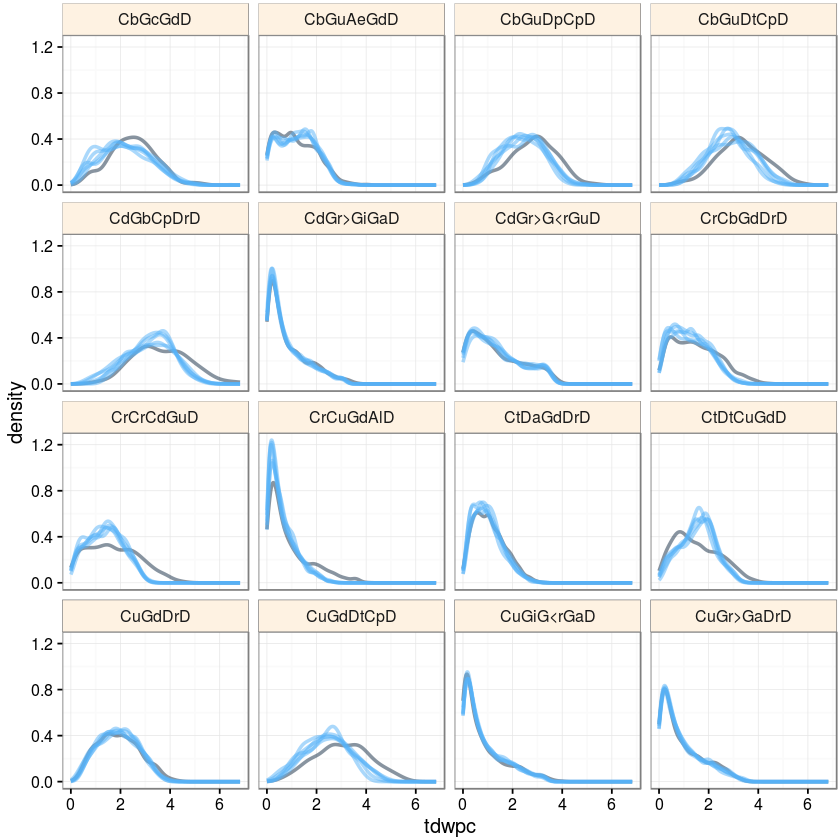

In [27]:
set.seed(0)
metapaths = sample(dwpc_df$metapath, 16)
dwpc_df %>%
  dplyr::filter(metapath %in% metapaths) %>%
  dplyr::filter(tdwpc > 0) %>%
  ggplot2::ggplot(ggplot2::aes(tdwpc, group=hetnet, color=permuted)) +
  ggplot2::stat_density(geom = 'line', alpha = 0.5, position='identity', size=1) +
  ggplot2::facet_wrap(~ metapath) +
  ggplot2::scale_color_continuous(guide = F) +
  ggplot2::theme_bw() +
  ggplot2::theme(
      plot.margin = grid::unit(c(2, 2, 2, 2), 'points'),
      strip.background=ggplot2::element_rect(fill='#FEF2E2')
  )